## Azure Data Lake Gen2 to Databricks Passthrough

In [0]:
configs = {
  "fs.azure.account.auth.type": "CustomAccessToken",
  "fs.azure.account.custom.token.provider.class": spark.conf.get("spark.databricks.passthrough.adls.gen2.tokenProviderClassName")
}
dbutils.fs.mount(
  source = "abfss://nvda-stocks@stockanalysisnvdadata.dfs.core.windows.net/",
  mount_point = "/mnt/nvda-stocks",
  extra_configs = configs)

In [0]:
dbutils.fs.ls("/mnt/nvda-stocks/raw-data")

[FileInfo(path='dbfs:/mnt/nvda-stocks/raw-data/ASML.csv', name='ASML.csv', size=765283, modificationTime=1730169397000),
 FileInfo(path='dbfs:/mnt/nvda-stocks/raw-data/CDNS.csv', name='CDNS.csv', size=922886, modificationTime=1730169413000),
 FileInfo(path='dbfs:/mnt/nvda-stocks/raw-data/NVDA.csv', name='NVDA.csv', size=749014, modificationTime=1730169430000),
 FileInfo(path='dbfs:/mnt/nvda-stocks/raw-data/SNPS.csv', name='SNPS.csv', size=752961, modificationTime=1730169446000),
 FileInfo(path='dbfs:/mnt/nvda-stocks/raw-data/Samsung.csv', name='Samsung.csv', size=408294, modificationTime=1730169383000),
 FileInfo(path='dbfs:/mnt/nvda-stocks/raw-data/TSM.csv', name='TSM.csv', size=741798, modificationTime=1730169464000)]

## Data Extraction

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import input_file_name  

# Path to the directory containing the files
path = "/mnt/nvda-stocks/raw-data/"

# Read all CSV files in the directory and add a column to organize values for each Stock 
df_combined = (
    spark.read
    .format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load(path + "*.csv")
    .withColumn("Name", input_file_name())  
)

# Extract the filename without the .csv extension
df_combined = df_combined.withColumn("Name", 
                                     F.regexp_replace(F.regexp_extract("Name", r"([^/]+$)", 1), r"\.csv$", ""))



## Data Transformation

In [0]:
# Get all float columns
float_cols = [field.name for field in df_combined.schema.fields if field.dataType.typeName() == 'double']  

# Apply rounding to each float column
for col in float_cols:
    df_combined = df_combined.withColumn(col, F.round(F.col(col), 3))



### Feature Engineering

Calculating Daily Return

In [0]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Define a window partitioned by each stock
window_spec = Window.partitionBy("Name").orderBy("Date")

# Calculate daily return
df_combined = df_combined.withColumn(
    "Daily Return", 
    (F.col("Close") - F.lag("Close", 1).over(window_spec)) / F.lag("Close", 1).over(window_spec)
)


Calculating Moving Averages (7-day and 30-day moving avaerage)

In [0]:
# 7-day moving average
df_combined = df_combined.withColumn(
    "7-day MA", 
    F.avg("Close").over(window_spec.rowsBetween(-6, 0))
)

# 30-day moving average
df_combined = df_combined.withColumn(
    "30-day MA", 
    F.avg("Close").over(window_spec.rowsBetween(-29, 0))
)


In [0]:

pdf_combined = df_combined.toPandas()


## Save transformed data back to storageaccount

In [0]:

output_path = "/mnt/nvda-stocks/transformed_data/df_combined.csv"

# Write the DataFrame to the specified path in CSV format
df_combined.write.mode("overwrite").csv(output_path, header=True)


In [0]:
dbutils.fs.ls("/mnt/nvda-stocks/transformed_data")

[FileInfo(path='dbfs:/mnt/nvda-stocks/transformed_data/df_combined.csv/', name='df_combined.csv/', size=0, modificationTime=1730334864000)]

## Exploratory Data Analysis (EDA)

In [0]:
import pandas as pd

# Generate summary statistics grouped by stock name
summary_stats = pdf_combined.groupby('Name')[['Close', 'Volume', 'Daily Return', '7-day MA', '30-day MA']].describe()
print(summary_stats)

daily_return_summary = summary_stats['Daily Return']['mean']
print("Daily Return Means by Stock:")
print(daily_return_summary)

# Calculate the mean of daily return means
mean_daily_return = daily_return_summary.mean()  # Use .mean() directly on the ndarray
print("Mean of Daily Return Means for all stocks:", mean_daily_return)


          Close                ...     30-day MA              
          count          mean  ...           75%           max
Name                           ...                            
ASML     7437.0    145.163835  ...    131.932000   1043.429667
CDNS     9400.0     36.465989  ...     25.270667    310.802667
NVDA     6463.0      6.921403  ...      4.206283    126.061533
SNPS     8208.0     77.576844  ...     53.962583    598.707000
Samsung  6199.0  28927.610905  ...  45885.833333  85530.000000
TSM      6786.0     31.209326  ...     37.629000    176.143000

[6 rows x 40 columns]
Daily Return Means by Stock:
Name
ASML       0.001270
CDNS       0.000965
NVDA       0.001953
SNPS       0.000823
Samsung    0.000613
TSM        0.000868
Name: mean, dtype: float64
Mean of Daily Return Means for all stocks: 0.001081915962044796


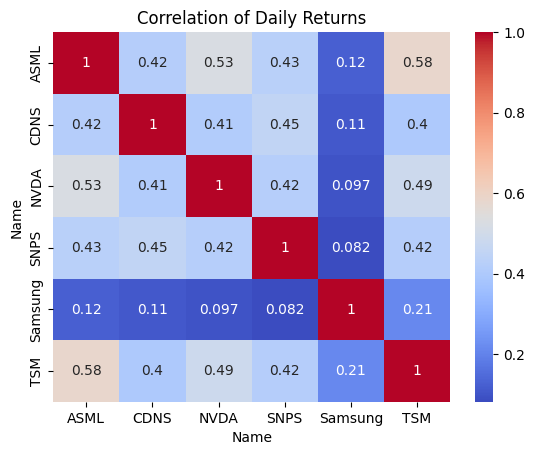

In [0]:
import matplotlib.pyplot as plt
daily_returns_pivot = pdf_combined.pivot(index='Date', columns='Name', values='Daily Return')
correlation_matrix = daily_returns_pivot.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation of Daily Returns")
plt.show()

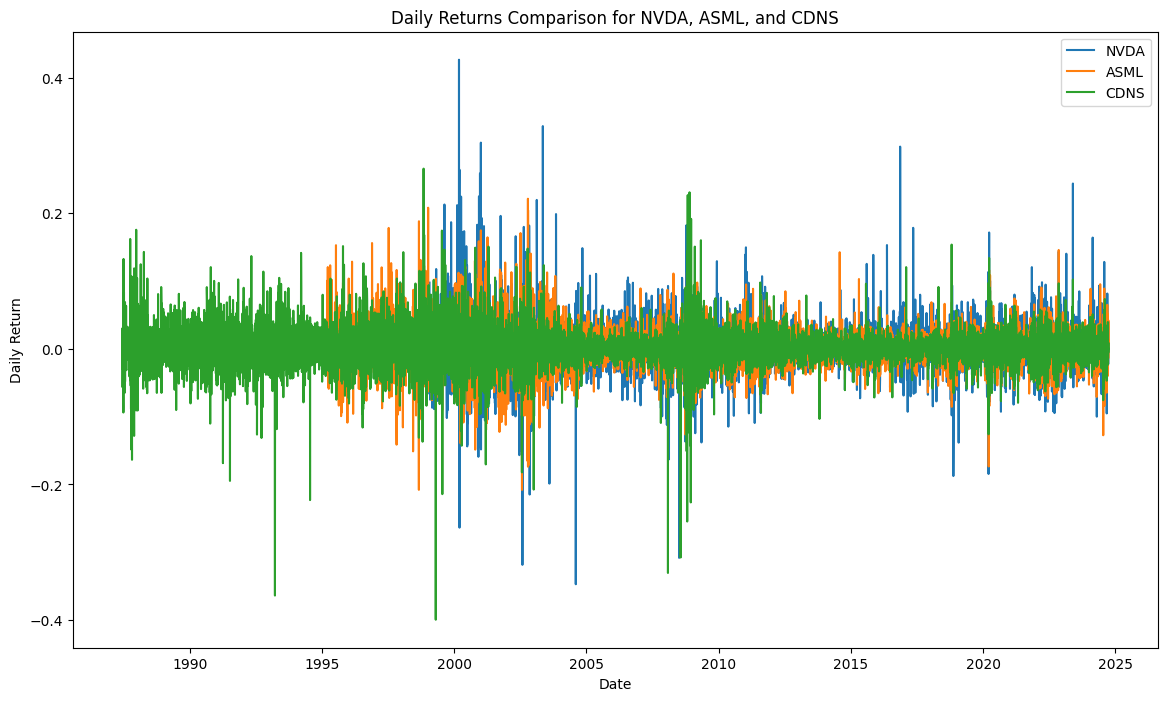

In [0]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(14, 8))

# Filter for only NVDA, ASML, and CDNS
stocks_to_plot = ['NVDA', 'ASML', 'CDNS']
filtered_data = pdf_combined[pdf_combined['Name'].isin(stocks_to_plot)]

# Plot each selected stock's daily returns on the same plot
for stock_name in stocks_to_plot:
    stock_data = filtered_data[filtered_data['Name'] == stock_name]
    plt.plot(stock_data['Date'], stock_data['Daily Return'], label=stock_name)

# Customize the plot
plt.title("Daily Returns Comparison for NVDA, ASML, and CDNS")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()


/root/.ipykernel/1106/command-2292760605005253-1460961474:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pdf_combined['30-day Volatility'] = pdf_combined.groupby('Name')['Daily Return'].apply(lambda x: x.rolling(window=30).std())


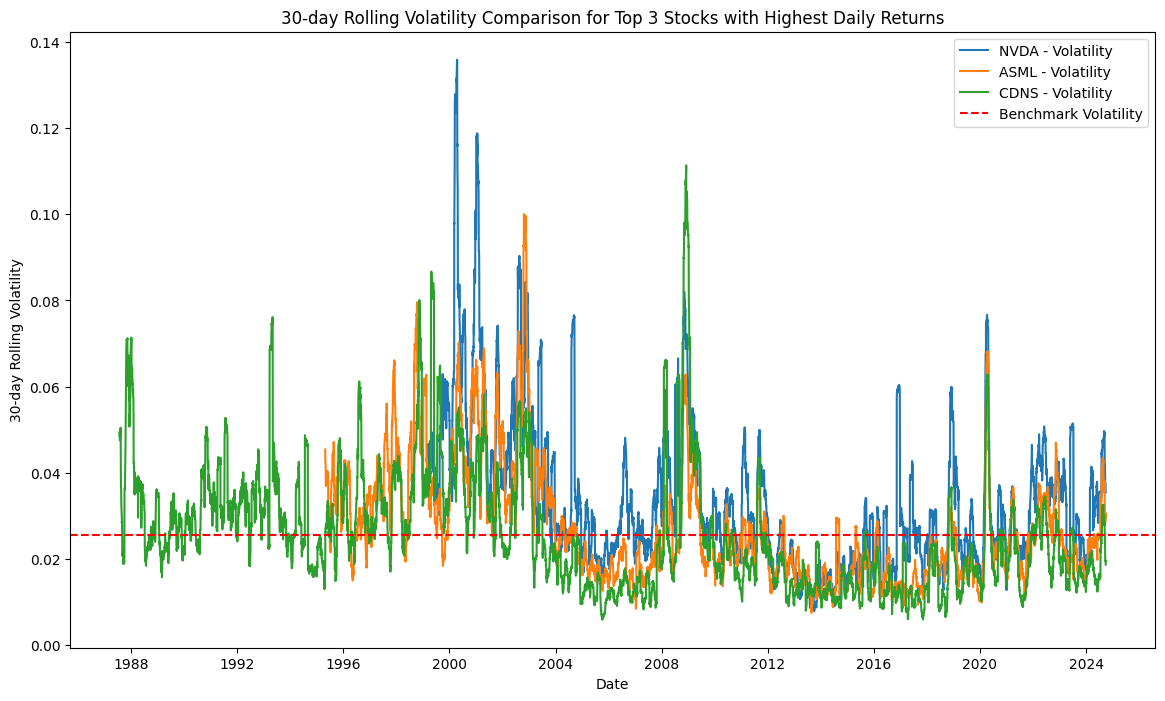

In [0]:
import matplotlib.pyplot as plt

# Calculate the average daily return for each stock
average_daily_returns = pdf_combined.groupby('Name')['Daily Return'].mean()

# Get the top 3 stocks with the highest average daily returns
top_stocks = average_daily_returns.nlargest(3).index.tolist()

# Calculate the 30-day rolling volatility for each stock
pdf_combined['30-day Volatility'] = pdf_combined.groupby('Name')['Daily Return'].apply(lambda x: x.rolling(window=30).std())

# Assume you have a benchmark return in `benchmark_returns`
benchmark_returns = mean_daily_return
benchmark_volatility = pdf_combined['Daily Return'].rolling(window=30).std().mean()

# Plot the rolling volatility for the top 3 stocks and compare to benchmark
plt.figure(figsize=(14, 8))
for stock_name in top_stocks:
    stock_data = pdf_combined[pdf_combined['Name'] == stock_name]
    plt.plot(stock_data['Date'], stock_data['30-day Volatility'], label=f"{stock_name} - Volatility")

# Add a horizontal line for the benchmark volatility
plt.axhline(y=benchmark_volatility, color='red', linestyle='--', label='Benchmark Volatility')

# Customize the plot
plt.title("30-day Rolling Volatility Comparison for Top 3 Stocks with Highest Daily Returns")
plt.xlabel("Date")
plt.ylabel("30-day Rolling Volatility")
plt.legend()
plt.show()
